In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize,OneHotEncoder
from itertools import cycle
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import Callback

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv(r'\RDM\Respiratory_Sound_Database\diagnosis_details.csv')
df.head()

,patient_id,diagnosis,recording_index,chest_location,acquisition_mode,recording_equipment
0,101,URTI,1b1,Al,sc,Meditron
1,101,URTI,1b1,Pr,sc,Meditron
2,102,Healthy,1b1,Ar,sc,Meditron
3,103,Asthma,2b2,Ar,mc,LittC2SE
4,104,COPD,1b1,Al,sc,Litt3200


In [ ]:
df.info()

In [4]:
#for prediction we only need first wo columns
df=df.iloc[:,:2]
df.head(1)

,patient_id,diagnosis
0,101,URTI


In [5]:
count=df['diagnosis'].value_counts()
count

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: diagnosis, dtype: int64

In [6]:
audio_files=glob.glob(r'\Lea!n\RDM\Respiratory_Sound_Database\audio_and_txt_files\*.wav')
print(os.path.basename(audio_files[0]).split('_')[0])

101


In [7]:
#new_file_name = f"{os.path.splitext(audio_files[0])[0]}_aug_{np.random.randint(1000)}{os.path.splitext(audio_files[0])[1]}"
new_file_name=f"{os.path.splitext(audio_files[0])[0]}_aug_{4}{os.path.splitext(audio_files[0])[1]}"
print(new_file_name)

\Lea!n\RDM\Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_4.wav


In [8]:
df2=pd.read_csv(r'\Lea!n\RDM\Respiratory_Sound_Database\patient_diagnosis.csv',names=['patient_id','diagnosis'])
df2.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [9]:
#checking values in new data
audio_files2=glob.glob(r'\Lea!n\RDM\Respiratory_Sound_Database\audio_and_txt_files\*.wav')


In [7]:
len(audio_files2)

6524

## Feature extraction

In [10]:
#function for extracting class labels
def extract_label(file,df):
    id=os.path.basename(file).split('_')[0]
    label=df[df['patient_id']==int(id)]['diagnosis'].values[0]
    return label


#function for extracting mfcc features
def feature_extraction(file,max_pad_len,n_features):
# Load the .wav file
    audio, sample_rate = librosa.load(file)
    # Extract the MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=n_features)
    
    # If the array is shorter than max_pad_len, pad it with zeros
    if (mfccs.shape[1] < max_pad_len):
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # If the array is longer than max_pad_len, truncate it
    elif (mfccs.shape[1] > max_pad_len):
        mfccs = mfccs[:, :max_pad_len]
        
    return mfccs


In [11]:
mfccs_features=[]
length=[]
labels=[]
max_pad_len=926
for i in audio_files2:
    mfccs=feature_extraction(i,max_pad_len,52)
    mfccs_features.append(mfccs)
    labels.append(extract_label(i,df2))
    length.append(mfccs.shape[1])

In [12]:
#converting fatures and labels to numpy arrays
mfccs_features=np.array(mfccs_features)
labels=np.array(labels)
print(f"features shape{mfccs_features.shape}")
print(f"Labels shape{labels.shape}")


features shape(6524, 52, 926)
Labels shape(6524,)


In [13]:
unique_labels, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

{0: 794, 1: 816, 2: 806, 3: 793, 4: 840, 5: 796, 6: 851, 7: 828}


### Model 

In [13]:
#encoding the labels
label_encoder=LabelEncoder()
labels=label_encoder.fit_transform(labels)
one_hot_labels=to_categorical(labels,num_classes=8)
one_hot_labels


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [14]:
def create_model():
    model=Sequential([
        Input(shape=(52,926)),
        
        Conv1D(64,5,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        Conv1D(128,3,padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # LSTM layers with return_sequences=True to keep temporal dimension
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        
        # Attention Layer
        SeqSelfAttention(attention_activation='sigmoid'),
        
        # Additional LSTM Layer
        LSTM(128),
        Dropout(0.5),
        
        # Dense Layers for Classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   
    return model 

### K_fold cross validation

In [15]:
# Split the dataset into training, validation, and test sets
X_train,X_test,y_train,y_test=train_test_split(mfccs_features,one_hot_labels,test_size=0.2,random_state=28,shuffle=True)

#early stopping to prevent overfitting
#early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [16]:
vc=np.argmax(y_train, axis=1)
vc

array([0, 4, 4, ..., 5, 2, 5], dtype=int64)

In [17]:
class CustomEarlyStopping(Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_accuracy')  # Changed 'accuracy' to 'val_accuracy'
        if np.greater(current, self.best):
            self.best = current
            self.wait = 0
            self.best_weights = self.model.get_weights()
        elif np.greater(self.best, 0.95):
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)

early_stopping = CustomEarlyStopping(patience=10)

In [65]:
# Define the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)

# Initialize lists to hold the validation scores
val_scores = []
histories = []  

# Split the data into training and validation sets
for train_index, val_index in skf.split(X_train, np.argmax(y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define the model
    model = create_model()

    # Define the early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    histories.append(history)
    val_score = model.evaluate(X_val_fold, y_val_fold)
    val_scores.append(val_score)

Epoch 1/100
131/131 [==============================] - 92s 554ms/step - loss: 1.7058 - accuracy: 0.3425 - val_loss: 1.6466 - val_accuracy: 0.3056
Epoch 2/100
131/131 [==============================] - 31s 239ms/step - loss: 1.2257 - accuracy: 0.5217 - val_loss: 1.1408 - val_accuracy: 0.5144
Epoch 3/100
131/131 [==============================] - 33s 250ms/step - loss: 1.1046 - accuracy: 0.5782 - val_loss: 1.2350 - val_accuracy: 0.4818
Epoch 4/100
131/131 [==============================] - 32s 244ms/step - loss: 0.8214 - accuracy: 0.6683 - val_loss: 1.3312 - val_accuracy: 0.5105
Epoch 5/100
131/131 [==============================] - 31s 239ms/step - loss: 0.7061 - accuracy: 0.7174 - val_loss: 0.5368 - val_accuracy: 0.7663
Epoch 6/100
131/131 [==============================] - 36s 276ms/step - loss: 0.6211 - accuracy: 0.7528 - val_loss: 1.4173 - val_accuracy: 0.5603
Epoch 7/100
131/131 [==============================] - 39s 298ms/step - loss: 0.5032 - accuracy: 0.7974 - val_loss: 0.9207 -

In [67]:

sum_accuracy = 0
sum_loss = 0


for i, score in enumerate(val_scores):
    print(f"Fold {i+1} - Loss: {score[0]}, Accuracy: {score[1]}")
    sum_loss += score[0]
    sum_accuracy += score[1]
    
avg_val_acc = sum_loss / len(val_scores)
avg_val_loss = sum_accuracy / len(val_scores)

print(f'Average validation accuracy: {avg_val_acc}')
print(f'Average validation loss: {avg_val_loss}')


Fold 1 - Loss: 0.03805924952030182, Accuracy: 0.9913793206214905
Fold 2 - Loss: 0.07804062217473984, Accuracy: 0.9779693484306335
Fold 3 - Loss: 0.06737184524536133, Accuracy: 0.9885057210922241
Fold 4 - Loss: 0.21783651411533356, Accuracy: 0.8659003973007202
Fold 5 - Loss: 0.043500036001205444, Accuracy: 0.9884947538375854
Average validation accuracy: 0.0889616534113884
Average validation loss: 0.9624499082565308


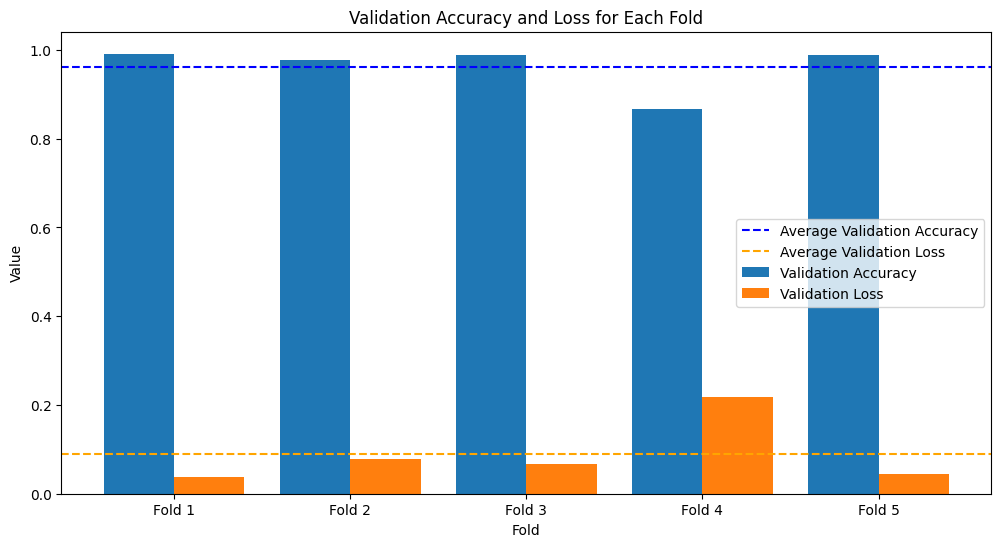

In [68]:
# Separate the validation accuracies and losses
final_val_losses = [score[0] for score in val_scores]
final_val_accs = [score[1] for score in val_scores]

# Calculate the average validation accuracy and loss
avg_val_loss = np.mean(final_val_losses)
avg_val_acc = np.mean(final_val_accs)

# Create an array with the positions of each bar on the x-axis
x = np.arange(len(final_val_accs))

# Create a bar chart of the validation accuracy
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, final_val_accs, 0.4, label='Validation Accuracy')
plt.bar(x + 0.2, final_val_losses, 0.4, label='Validation Loss')

# Add the average validation accuracy and loss as horizontal lines
plt.axhline(avg_val_acc, color='blue', linestyle='dashed', label='Average Validation Accuracy')
plt.axhline(avg_val_loss, color='orange', linestyle='dashed', label='Average Validation Loss')

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Value')
plt.title('Validation Accuracy and Loss for Each Fold')
plt.xticks(x, [f'Fold {i+1}' for i in range(len(final_val_accs))])

# Add a legend
plt.legend()

# Show the chart
plt.show()

In [18]:
# Define the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)

# Initialize lists to hold the validation scores
val_scores = []
histories = []  

# Split the data into training and validation sets
for train_index, val_index in skf.split(X_train, np.argmax(y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define the model
    model = create_model()

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    histories.append(history)
    val_score = model.evaluate(X_val_fold, y_val_fold)
    val_scores.append(val_score)

Epoch 1/100
131/131 [==============================] - 27s 109ms/step - loss: 1.7438 - accuracy: 0.3066 - val_loss: 1.6245 - val_accuracy: 0.4148
Epoch 2/100
131/131 [==============================] - 16s 121ms/step - loss: 1.3068 - accuracy: 0.4750 - val_loss: 1.1206 - val_accuracy: 0.5335
Epoch 3/100
131/131 [==============================] - 13s 98ms/step - loss: 1.0336 - accuracy: 0.5863 - val_loss: 0.8997 - val_accuracy: 0.6130
Epoch 4/100
131/131 [==============================] - 13s 96ms/step - loss: 0.8211 - accuracy: 0.6683 - val_loss: 1.4487 - val_accuracy: 0.5469
Epoch 5/100
131/131 [==============================] - 13s 101ms/step - loss: 0.6997 - accuracy: 0.7344 - val_loss: 0.8349 - val_accuracy: 0.7011
Epoch 6/100
131/131 [==============================] - 15s 111ms/step - loss: 0.6089 - accuracy: 0.7727 - val_loss: 1.3082 - val_accuracy: 0.6734
Epoch 7/100
131/131 [==============================] - 17s 129ms/step - loss: 0.4477 - accuracy: 0.8151 - val_loss: 1.2814 - v

In [19]:

sum_accuracy = 0
sum_loss = 0


for i, score in enumerate(val_scores):
    print(f"Fold {i+1} - Loss: {score[0]}, Accuracy: {score[1]}")
    sum_loss += score[0]
    sum_accuracy += score[1]
    
avg_val_acc = sum_accuracy / len(val_scores)
avg_val_loss = sum_loss / len(val_scores)

print(f'Average validation accuracy: {avg_val_acc}')
print(f'Average validation loss: {avg_val_loss}')


Fold 1 - Loss: 0.02661413513123989, Accuracy: 0.9961685538291931
Fold 2 - Loss: 0.06217806041240692, Accuracy: 0.9913793206214905
Fold 3 - Loss: 0.044056300073862076, Accuracy: 0.9913793206214905
Fold 4 - Loss: 0.022400762885808945, Accuracy: 0.9961685538291931
Fold 5 - Loss: 0.03176252171397209, Accuracy: 0.997123658657074
Average validation accuracy: 0.9944438815116883
Average validation loss: 0.037402356043457985


In [27]:
print(np.mean(final_val_losses))
print(np.mean(final_val_accs))

0.037402356043457985
0.9944438815116883


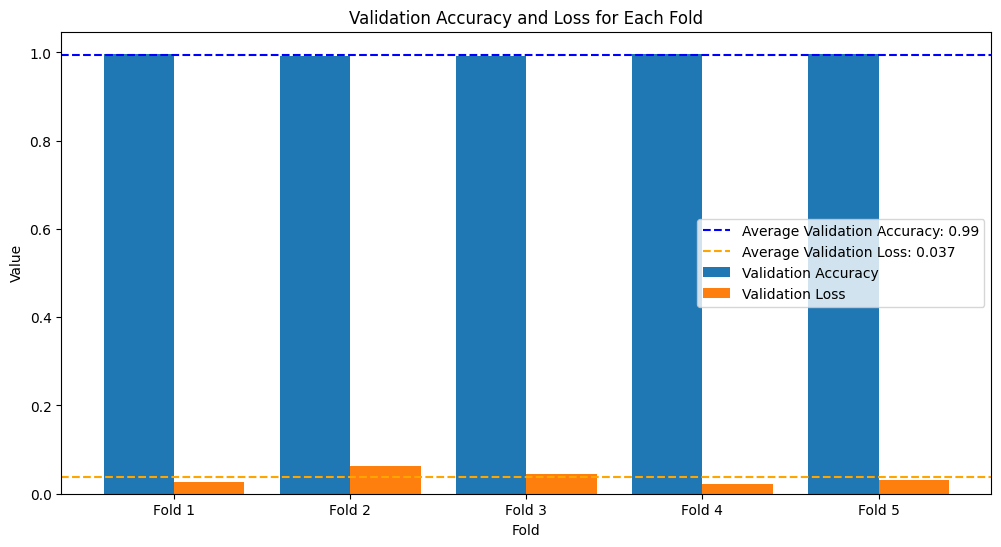

In [29]:
# Separate the validation accuracies and losses
final_val_losses = [score[0] for score in val_scores]
final_val_accs = [score[1] for score in val_scores]

# Calculate the average validation accuracy and loss
avg_val_loss = np.mean(final_val_losses)
avg_val_acc = np.mean(final_val_accs)

# Create an array with the positions of each bar on the x-axis
x = np.arange(len(final_val_accs))

# Create a bar chart of the validation accuracy
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, final_val_accs, 0.4, label='Validation Accuracy')
plt.bar(x + 0.2, final_val_losses, 0.4, label='Validation Loss')

# Add the average validation accuracy and loss as horizontal lines
plt.axhline(avg_val_acc, color='blue', linestyle='dashed', label=f'Average Validation Accuracy: {avg_val_acc:.2f}')
plt.axhline(avg_val_loss, color='orange', linestyle='dashed', label=f'Average Validation Loss: {avg_val_loss:.3f}')

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('Value')
plt.title('Validation Accuracy and Loss for Each Fold')
plt.xticks(x, [f'Fold {i+1}' for i in range(len(final_val_accs))])

# Add a legend
plt.legend()

# Show the chart
plt.show()

In [26]:
# #applying one_hot encoding
# encoder=OneHotEncoder(sparse=False,handle_unknown='ignore')
# y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
# y_test_encoded = encoder.transform(y_test.reshape(-1, 1))